## Maximizing Revenue for Taxi Cab Drivers through Payment Type analysis

### Problem Statement
In the fast-paced taxi-booking sector, making the most of revenue is essential.

### Objective
#### This project investigates how payment type affects fare amounts in taxi services. The objective is to determine if nudging customers towards specific payment methods can maximize revenue for drivers without negatively impacting customer experience.

### Research Question
#### What factors influence a customer's choice to pay using either a card or cash for their trip bill?

### Important Libraries

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
import statsmodels.api as sm 
warnings.filterwarnings('ignore')

### Loading The Dataset


In [147]:
%reload_ext sql

In [148]:
DB_USER = "postgres"
DB_PASSWORD = "Sah%407920S12"
DB_HOST = "localhost"  # Change if your database is hosted elsewhere
DB_PORT = "5432"  # Default PostgreSQL port
DB_NAME = "test_db"

# # Create connection string
CONN_STRING = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Connect to PostgreSQL
%sql $CONN_STRING

In [149]:
query = "SELECT * FROM taxi_data LIMIT 100000;" 
df = pd.read_sql(query, CONN_STRING)

# Display the dataframe
df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-15 21:19:56,2023-01-15 21:25:18,1,0.99,1,N,161,43,1,7.2,1.0,0.5,3.66,0.00,1,15.86,2.5,0.00,5.366667
1,2,2023-01-15 21:29:03,2023-01-15 21:40:45,1,1.75,1,N,163,234,1,12.1,1.0,0.5,3.42,0.00,1,20.52,2.5,0.00,11.700000
2,2,2023-01-15 21:42:30,2023-01-15 21:58:58,1,3.42,1,N,234,140,1,18.4,1.0,0.5,1.00,0.00,1,24.40,2.5,0.00,16.466667
3,2,2023-01-15 21:35:00,2023-01-15 21:55:09,1,10.25,1,N,264,162,1,40.8,6.0,0.5,11.72,6.55,1,70.32,2.5,1.25,20.150000
4,2,2023-01-15 21:24:14,2023-01-15 22:00:36,2,20.83,2,N,132,238,1,70.0,0.0,0.5,4.00,6.55,1,85.80,2.5,1.25,36.366667


## Exploratory Data analysis

In [150]:
# df.to_csv('2023_Yellow_Taxi_Trip_Data_sample.csv', index=False)
df = pd.read_csv('2023_Yellow_Taxi_Trip_Data_sample.csv')

In [151]:
# df.shape, filter data as per the requirement that can potentially be used to determine which payment type is more preferred by the passengers.
df = df[['passenger_count', 'payment_type', 'fare_amount', 'trip_distance', 'duration']]
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,2,9.3,0.97,8.433333
1,1,1,7.9,1.10,6.316667
2,1,1,14.9,2.51,12.750000
3,0,1,12.1,1.90,9.616667
4,1,1,11.4,1.43,10.833333
...,...,...,...,...,...
99995,1,1,21.2,3.72,20.150000
99996,1,1,8.6,0.00,8.100000
99997,1,1,4.4,0.00,2.450000
99998,1,1,7.9,0.00,7.250000


In [152]:
# check for missing values/rows
# df.isnull().sum()

# '''
# since here are no missing values, we can proceed to the next step
# but if there are missing values, we can either drop the rows with missing values or fill them with the mean or median of the column. so for this we need to check if the missing values are large portion of actual data or not
# '''
# # drop missing values
# passenger_count_missing_values = 65441
# # now check percentage of this in actual dataset
# (passenger_count_missing_values/len(df))*100
# # if this percentage is less than 5% then we can drop the missing values
# df.dropna(inplace=True)

In [153]:
# now check for duplicates
df[df.duplicated()]
''' this will return an empty dataframe if there are no duplicates in the dataset, if there are duplicates then we can drop them using the following code
df.drop_duplicates(inplace=True)
'''
df.drop_duplicates(inplace=True)

In [154]:
df.shape

(96423, 5)

In [155]:
# now we can see passenger_count and payment_type are categorical variables, so we need to check the unique values in these columns and in what percentage they are present in the their respective columns.
# here if we get percentage very low even less than 1% then we can drop that column as it will not affect the model much

# to remove
df = df[(df['passenger_count'] != 0) & (df['passenger_count'] < 5)]
df['passenger_count'].value_counts(normalize=True)*100


passenger_count
1    67.580281
2    21.687742
3     6.398557
4     4.333420
Name: proportion, dtype: float64

In [156]:
df['payment_type'].value_counts(normalize=True)*100


payment_type
1    73.550819
2    24.322122
4     1.436145
3     0.690914
Name: proportion, dtype: float64

In [157]:
# as we are only interested in cash and credit card payment type, we can remove the other payment types
df = df[(df['payment_type']<3)]

In [158]:
df['payment_type'].replace([1,2], ['Card', 'Cash'], inplace=True)

In [159]:
# need to know about statistical analysis of the data
df.describe()

,passenger_count,fare_amount,trip_distance,duration
count,90094.000000,90094.000000,90094.000000,90094.000000
mean,1.476103,22.587590,5.210606,17.047115
std,0.798754,21.282867,207.811742,55.068366
min,1.000000,-270.320000,0.000000,0.000000
25%,1.000000,9.300000,1.260000,7.066667
50%,1.000000,14.200000,2.300000,12.083333
75%,2.000000,26.800000,5.140000,20.000000
max,4.000000,496.500000,62359.520000,2596.200000


(array([7.9585e+04, 9.7990e+03, 3.6200e+02, 8.1000e+01, 1.9000e+01,
        1.3000e+01, 2.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([1.00000e-02, 4.96590e+01, 9.93080e+01, 1.48957e+02, 1.98606e+02,
        2.48255e+02, 2.97904e+02, 3.47553e+02, 3.97202e+02, 4.46851e+02,
        4.96500e+02]),
 <BarContainer object of 10 artists>)

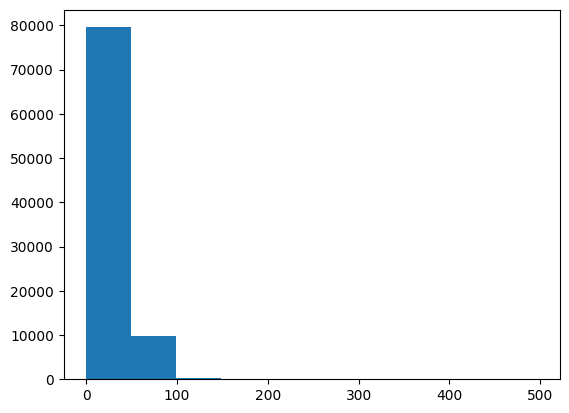

In [160]:
# Step 1 Deal with Negative Values as they wrong values
df = df[df['fare_amount'] > 0]
# Step 2 identify the outliers as you can see 75% and max, the value differences is very large so here can be possible to check:
plt.hist(df['fare_amount'])


# to remove outliers we have two ways
1. z score
    use when data is normal distribution using df.description()
2. interquartile range
    so use this

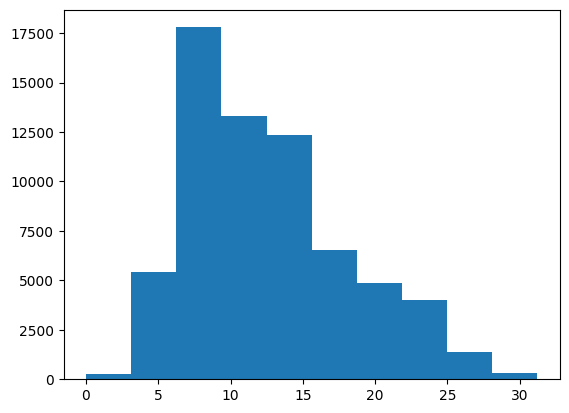

In [173]:
# using interquartile range to remove outliers

# Assuming df is your DataFrame
columns = ['fare_amount','trip_distance', 'duration']
for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    IQR = q3 - q1

    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR

    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

plt.hist(df['fare_amount'])
plt.show()

In [174]:
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,Cash,9.3,0.97,8.433333
1,1,Card,7.9,1.10,6.316667
2,1,Card,14.9,2.51,12.750000
3,1,Card,11.4,1.43,10.833333
4,1,Card,12.8,1.84,12.300000
...,...,...,...,...,...
70970,1,Card,21.2,3.72,20.150000
70971,1,Card,8.6,0.00,8.100000
70972,1,Card,4.4,0.00,2.450000
70973,1,Card,7.9,0.00,7.250000


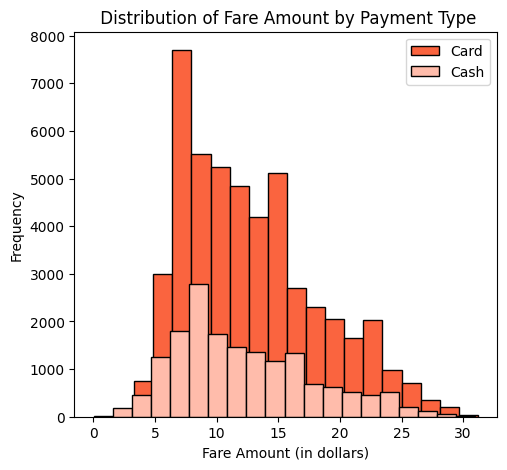

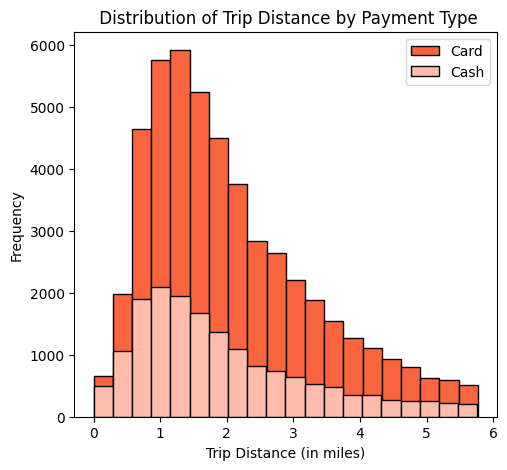

In [175]:
# Now create some visuals
plt.figure(figsize=(12, 5)) # this creates a figure 8 inch wide, 4 inch high
plt.subplot(1, 2, 1) # this creates a grid of 1 row and 2 columns and sets the active subplot to the first one
plt.hist(df[df['payment_type'] == 'Card']['fare_amount'],histtype = 'barstacked', bins = 20, edgecolor = 'k',color = '#FA643F',label = 'Card') # this creates a histogram of the 'fare_amount' column for the 'Card' payment type
plt.hist(df[df['payment_type'] == 'Cash']['fare_amount'],histtype = 'barstacked', bins = 20, edgecolor = 'k',color = '#FFBCAB',label = 'Cash')
plt.title(' Distribution of Fare Amount by Payment Type') # this sets the title of the active subplot
plt.xlabel('Fare Amount (in dollars)') # this sets the x-axis label of the active subplot
plt.ylabel('Frequency') # this sets the y-axis label of the active subplot
plt.legend() # this displays the legend
# plt.show() # this displays the figure

# simmilarly make distribution of trip_distance 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df[df['payment_type'] == 'Card']['trip_distance'],histtype = 'barstacked', bins = 20, edgecolor = 'k',color = '#FA643F',label = 'Card')
plt.hist(df[df['payment_type'] == 'Cash']['trip_distance'],histtype = 'barstacked', bins = 20, edgecolor = 'k',color = '#FFBCAB',label = 'Cash')
plt.title(' Distribution of Trip Distance by Payment Type')
plt.xlabel('Trip Distance (in miles)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# nOW FIND THE MEAN AND STANDARD DEVIATION OF THE FARE AMOUNT and trip_distance for each payment type
df.groupby('payment_type').agg({'fare_amount': ['mean', 'std'], 'trip_distance': ['mean', 'std'],})

# CONCLUSION: Payment Type and Fare Amount: On average, trips paid by card have a slightly higher fare amount compared to those paid by cash. However, the difference is not very large.
# Payment Type and Trip Distance: On average, trips paid by card are slightly longer in distance compared to those paid by cash. Again, the difference is not very large.
# Variability: The variability (standard deviation) in both fare amount and trip distance is slightly lower for card payments compared to cash payments, suggesting that card payments might be more consistent in terms of fare amount and trip distance.


fare_amount           trip_distance          
                    mean       std          mean       std
payment_type                                              
Card           12.790974  5.474837      2.066434  1.245423
Cash           12.303382  5.607041      1.933532  1.299362

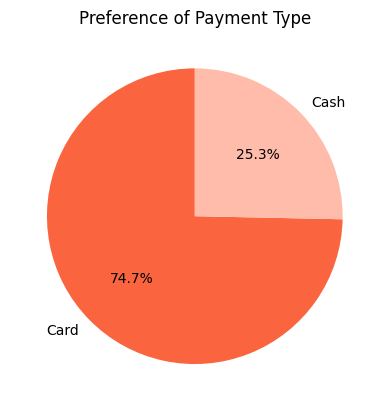

In [ ]:
# Now we need to calculate how much percentage of customers prefers card over cash using pie chart.

plt.title('Preference of Payment Type')
plt.pie(df['payment_type'].value_counts(normalize=True)*100, labels = ['Card', 'Cash'], autopct='%1.1f%%', startangle=90, colors = ['#FA643F', '#FFBCAB'])

plt.show()

In [ ]:
# Now we need to check how number of passengers Can affect the willingness of a customer to pay using card or cash.
passenger_count = df.groupby(['payment_type', 'passenger_count'])[['passenger_count']].count()
df

,passenger_count,payment_type,fare_amount,trip_distance,duration
0,1,Cash,9.3,0.97,8.433333
1,1,Card,7.9,1.10,6.316667
2,1,Card,14.9,2.51,12.750000
3,1,Card,11.4,1.43,10.833333
4,1,Card,12.8,1.84,12.300000
...,...,...,...,...,...
70970,1,Card,21.2,3.72,20.150000
70971,1,Card,8.6,0.00,8.100000
70972,1,Card,4.4,0.00,2.450000
70973,1,Card,7.9,0.00,7.250000


In [179]:
passenger_count.rename(columns = {'passenger_count': 'count'}, inplace = True)
passenger_count.reset_index(inplace = True)
passenger_count['perc'] = (passenger_count['count']/passenger_count['count'].sum())*100

passenger_count

,payment_type,passenger_count,count,perc
0,Card,1,34119,51.524487
1,Card,2,10742,16.221930
2,Card,3,2908,4.391489
3,Card,4,1675,2.529485
4,Cash,1,11367,17.165768
5,Cash,2,3373,5.093704
6,Cash,3,1120,1.691357
7,Cash,4,915,1.381779


In [180]:
df1 = pd.DataFrame(columns=['payment_type',1,2,3,4])
df1['payment_type'] = ['Card', 'Cash']
df1.iloc[0,1:] = passenger_count[passenger_count['payment_type'] == 'Card']['perc'].values
df1.iloc[1,1:] = passenger_count[passenger_count['payment_type'] == 'Cash']['perc'].values
df1

,payment_type,1,2,3,4
0,Card,51.524487,16.22193,4.391489,2.529485
1,Cash,17.165768,5.093704,1.691357,1.381779


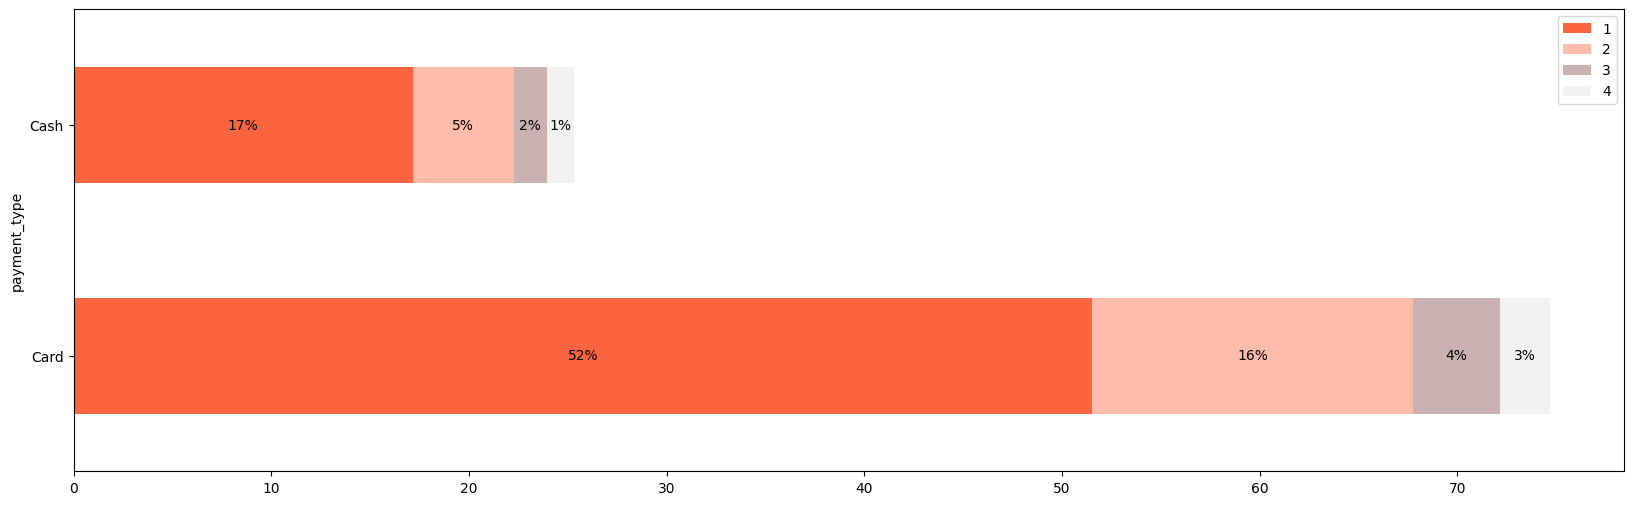

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
df1.plot(x = 'payment_type', kind = 'barh', stacked = True, color = ['#FA643F', '#FFBCAB', '#CBB2B2', '#F1F1F1', '#FD9F9F', '#FFE8C4'], ax=ax)

#  Add Percentage text
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2,
            y + height/2,
            '{:.0f}%'.format(width),
            horizontalalignment='center',
            verticalalignment='center',
            ) # this sets the font size of the text
    
# Conclusion: The percentage of customers who prefer card payments is higher for trips with 1 passenger compared to trips with 2, 3, or 4 passengers. This suggests that customers who travel alone are more likely to pay by card compared to customers who travel in groups.
# here we can see payment type are preferred as 25.3% for cash and 74.7% for card.
# so out of 74.7% of card payment, 45.7% are for 1 passenger, 20.3% for 2 passengers, 6.9% for 3 passengers and 1.8% for 4 passengers.
# similarly out of 25.3% of cash payment, 15.3% are for 1 passenger, 6.9% for 2 passengers, 2.3% for 3 passengers and 0.8% for 4 passengers.

### Now the analysis is done, now we need to show the hypothesis testing to check the significance of the results obtained. 

Null Hypothesis: There is no significant difference in the mean fare amount between customers who use credit cards and customer who use cash payments.
Alternative hypothesis: There is a difference in the mean fare amount between customers who use credit cards and customer who use cash payments.
    
    



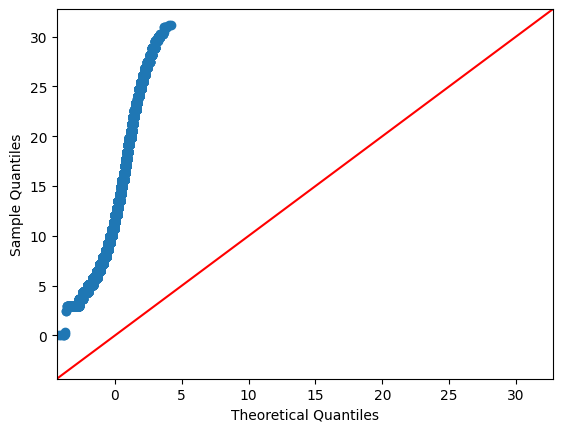

In [182]:
# # Ensure 'fare_amount' column is present in the 
sm.qqplot(df['fare_amount'], line ='45')
plt.show()
# if the data is normally distributed then the data points will fall on the straight line, if not then we need to apply some transformation to make it normally distributed


In [ ]:
# using ttest to check the difference between the fare amount of card and cash payment type

card_sample = df[df['payment_type'] == 'Card']['fare_amount']
cash_sample = df[df['payment_type'] == 'Cash']['fare_amount']

t_stat, p_val = st.ttest_ind(card_sample, cash_sample, equal_var = False)
print('t-statistic:', t_stat, 'p-value:', p_val)

# Conclusion: The p-value is less than 0.05, which means that we reject the null hypothesis. This suggests that there is a statistically significant difference between the fare amounts of trips paid by card and cash. However, the difference is not very large in practical terms.

t-statistic: 9.790343861380085 p-value: 1.345197383935251e-22
